In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from sklearn.metrics import mean_squared_error
import sys
sys.path.insert(0, '../python/')
from helpers import *

import statsmodels.api as sm
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 14})

/Users/raficg/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv('../../data/train/dates.csv', parse_dates=['full_date'])
data.replace(['Resort Hotel', 'City Hotel'], [0, 1], inplace=True)

In [3]:
(resort_bookings_by_day, resort_cancellations_by_day,
 city_bookings_by_day, city_cancellations_by_day) = get_day_counts(data)

Text(0.5, 1.0, 'Non-Cancellations 3 Day Moving Avg.')

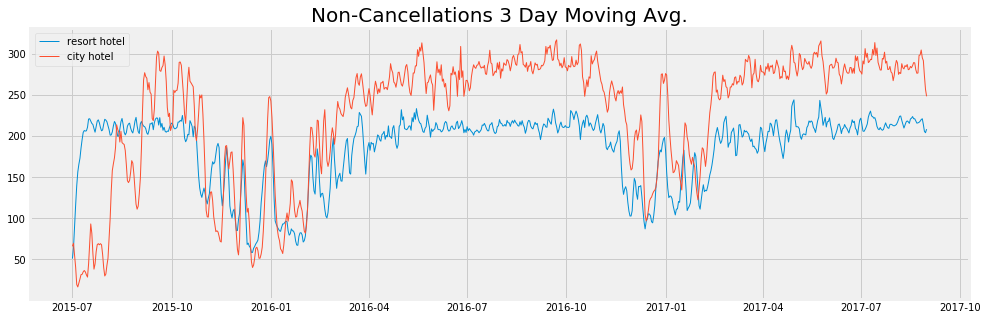

In [4]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(sorted(data['full_date'].unique()), moving_avg(resort_bookings_by_day), linewidth=1, label='resort hotel')
ax.plot(sorted(data['full_date'].unique()), moving_avg(city_bookings_by_day), linewidth=1, label='city hotel')
ax.legend()
ax.set_title('Non-Cancellations 3 Day Moving Avg.', fontsize=20)

Text(0.5, 1.0, 'All Reservations 3 Day Moving Avg.')

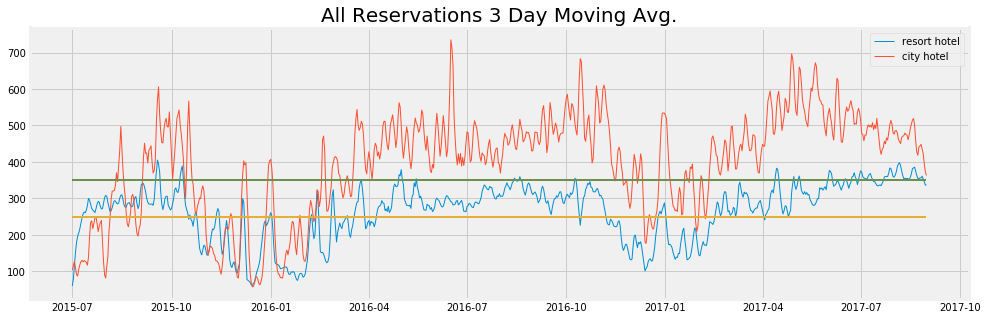

In [5]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(sorted(data['full_date'].unique()), moving_avg(np.array(resort_cancellations_by_day) + np.array(resort_bookings_by_day)), linewidth=1, label='resort hotel')
ax.plot(sorted(data['full_date'].unique()), moving_avg(np.array(city_cancellations_by_day) + np.array(city_bookings_by_day)), linewidth=1, label='city hotel')
ax.plot(sorted(data['full_date'].unique()), [250] * len(city_cancellations_by_day), linewidth=2)
ax.plot(sorted(data['full_date'].unique()), [350] * len(city_cancellations_by_day), linewidth=2)
ax.legend()
ax.set_title('All Reservations 3 Day Moving Avg.', fontsize=20)

In [6]:
resorts = pd.Series(data=(np.array(resort_bookings_by_day) + 
                          np.array(resort_cancellations_by_day)), 
                    index=sorted(data['full_date'].unique()))
citys = pd.Series(data=(np.array(city_bookings_by_day) + 
                          np.array(city_cancellations_by_day)), 
                    index=sorted(data['full_date'].unique()))

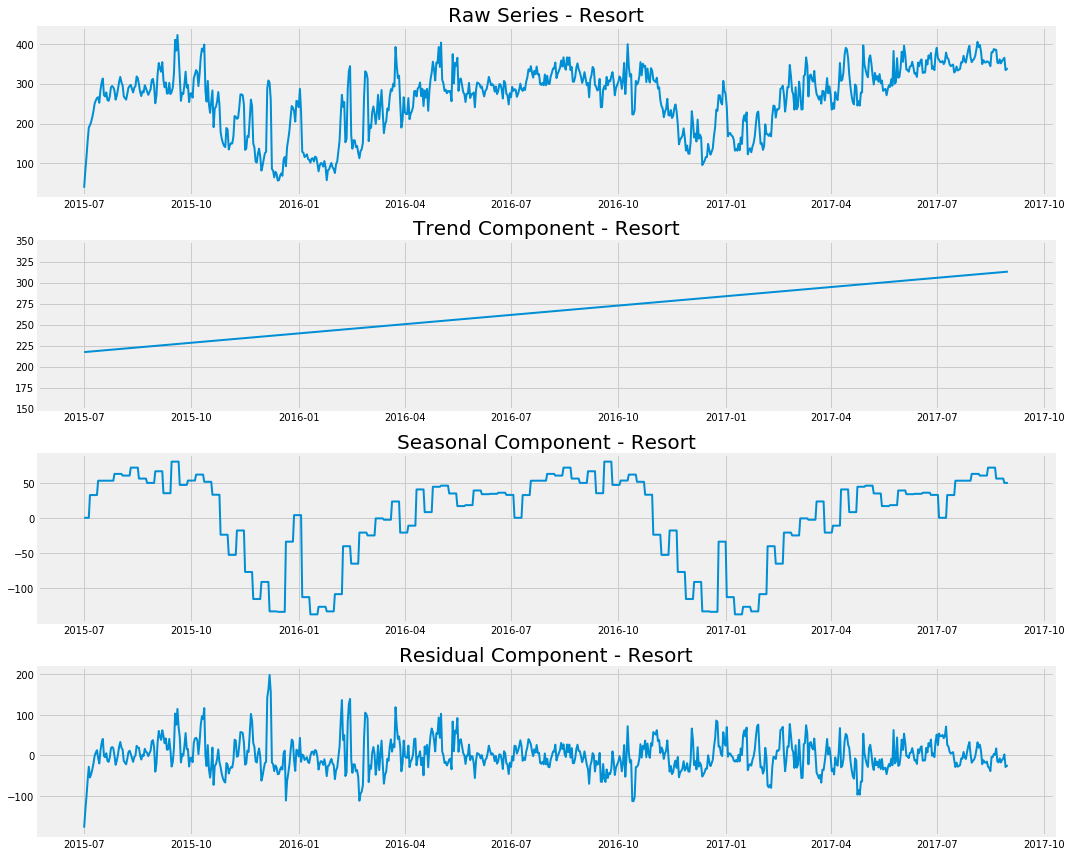

In [7]:
fig, ax = plt.subplots(4, 1, figsize=(15, 12))

plot_decomposition(ax, 'Resort', resorts)
fig.tight_layout()

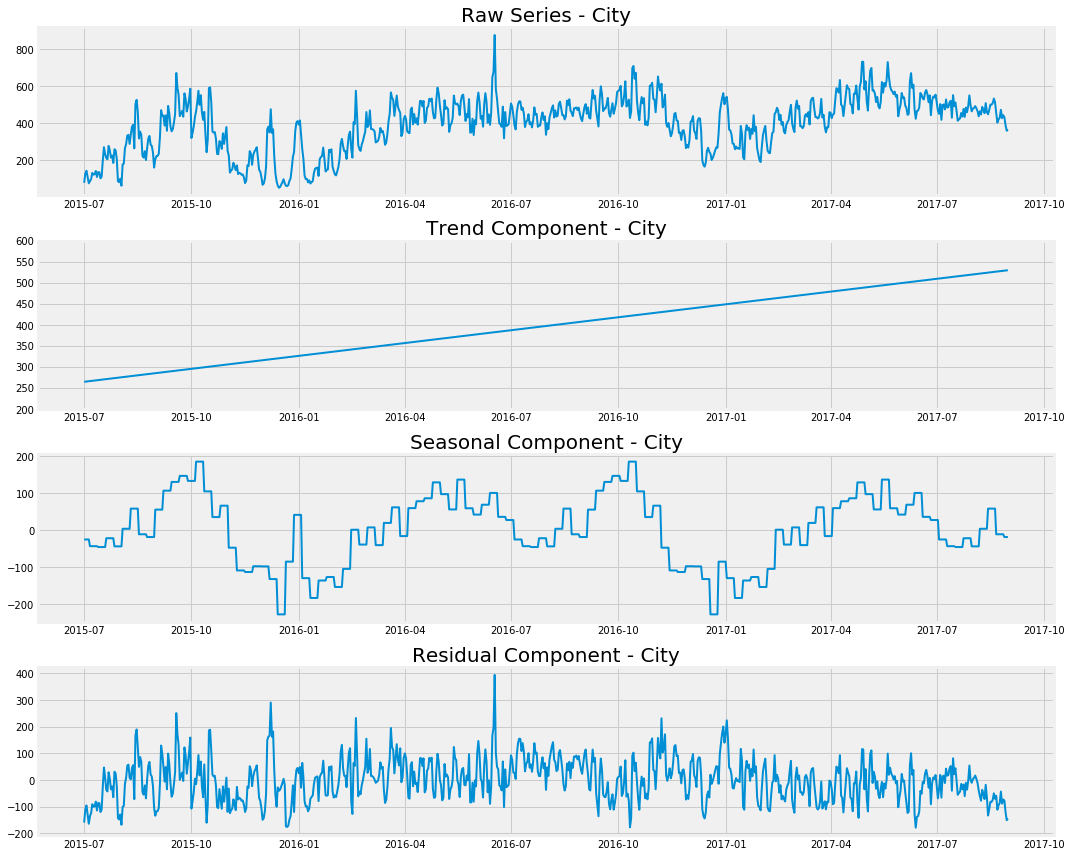

In [8]:
fig, ax = plt.subplots(4, 1, figsize=(15, 12))

plot_decomposition(ax, 'City', citys)
fig.tight_layout()

In [9]:
from fbprophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX

Importing plotly failed. Interactive plots will not work.


In [10]:
resort_train = resorts[np.where(~(resorts.index >= datetime.datetime.strptime('2017-06-01', '%Y-%m-%d')))[0]]
resort_test = resorts[np.where((resorts.index >= datetime.datetime.strptime('2017-06-01', '%Y-%m-%d')))[0]]

city_train = citys[np.where(~(citys.index >= datetime.datetime.strptime('2017-06-01', '%Y-%m-%d')))[0]]
city_test = citys[np.where((citys.index >= datetime.datetime.strptime('2017-06-01', '%Y-%m-%d')))[0]]

# Baseline: Predict Average From Years Before

In [11]:
def baseline_predict(series, date):
    df = pd.DataFrame()
    df['ds'] = series.index
    df['y'] = series.values
    df = df[15:]

    df['month'] = df['ds'].dt.month
    df['day_of_month'] = df['ds'].dt.day
    df['year'] = df['ds'].dt.year
    
    if type(date) == str:
        [yr, m, d] = date.split('-')
    else:
        m = date.month
        d = date.day
        
    l = fit_linear_trend(series)
    slope = 1 + (l[1] - l[0] / 1)
    #slope=1
    
    return df[(df['month'] == int(m)) & (df['day_of_month'] == int(d))]['y'].mean() * slope

Text(0.5, 1.0, 'Resort Baseline')

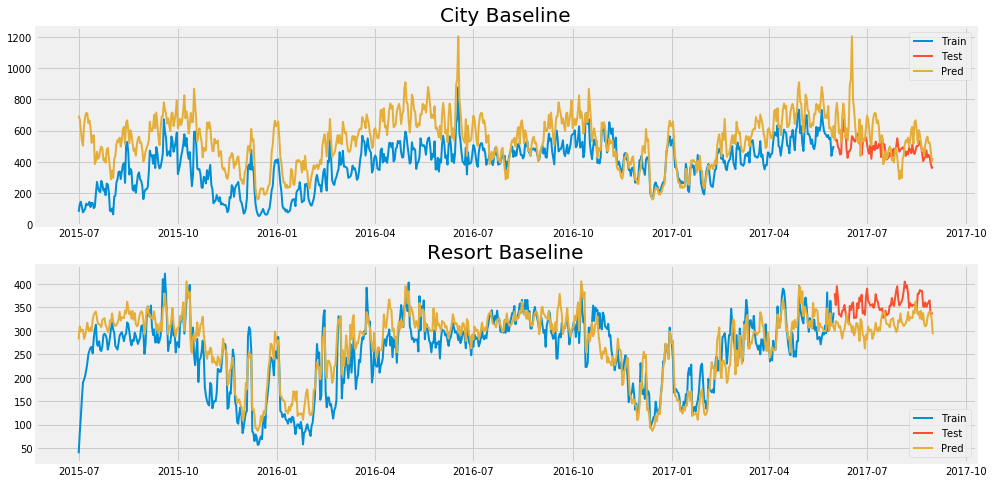

In [12]:
resort_pred = []
for item in resort_train.index:
    resort_pred.append(baseline_predict(resort_train, item))
    
for item in resort_test.index:
    resort_pred.append(baseline_predict(resort_train, item))

    
city_pred = []
for item in city_train.index:
    city_pred.append(baseline_predict(city_train, item))
    
for item in city_test.index:
    city_pred.append(baseline_predict(city_train, item))

fig, ax = plt.subplots(2, figsize=(15, 8))

ax[0].plot(city_train, label='Train', linewidth=2)
ax[0].plot(city_test, label='Test', linewidth=2)
ax[0].plot(city_train.index.append(city_test.index), city_pred, label='Pred', linewidth=2)
ax[0].legend()
ax[0].set_title('City Baseline', fontsize=20)

ax[1].plot(resort_train, label='Train', linewidth=2)
ax[1].plot(resort_test, label='Test', linewidth=2)
ax[1].plot(resort_train.index.append(resort_test.index), resort_pred, label='Pred', linewidth=2)
ax[1].legend()
ax[1].set_title('Resort Baseline', fontsize=20)

In [13]:
print('City Train RMSE: %0.2f' % (np.sqrt(mean_squared_error(city_train.values, city_pred[0:701]))))
print('City Test RMSE: %0.2f' % (np.sqrt(mean_squared_error(city_test.values, city_pred[701:]))))

print('Resort Train RMSE: %0.2f' % (np.sqrt(mean_squared_error(resort_train.values, resort_pred[0:701]))))
print('Resort Test RMSE: %0.2f' % (np.sqrt(mean_squared_error(resort_test.values, resort_pred[701:]))))

City Train RMSE: 186.61
City Test RMSE: 146.33
Resort Train RMSE: 41.24
Resort Test RMSE: 48.47


# SARIMA

In [14]:
test = sm.tsa.stattools.adfuller(resort_train)
print('ADF p-value for resort: %0.2f' % test[1])
test = sm.tsa.stattools.adfuller(resort_train.diff()[1:])
print('ADF p-value for differenced resort: %0.2f' % test[1])
print()
test = sm.tsa.stattools.adfuller(city_train)
print('ADF p-value for city: %0.2f' % test[1])
test = sm.tsa.stattools.adfuller(city_train.diff()[1:])
print('ADF p-value for differenced city: %0.2f' % test[1])

ADF p-value for resort: 0.29
ADF p-value for differenced resort: 0.00

ADF p-value for city: 0.36
ADF p-value for differenced city: 0.00


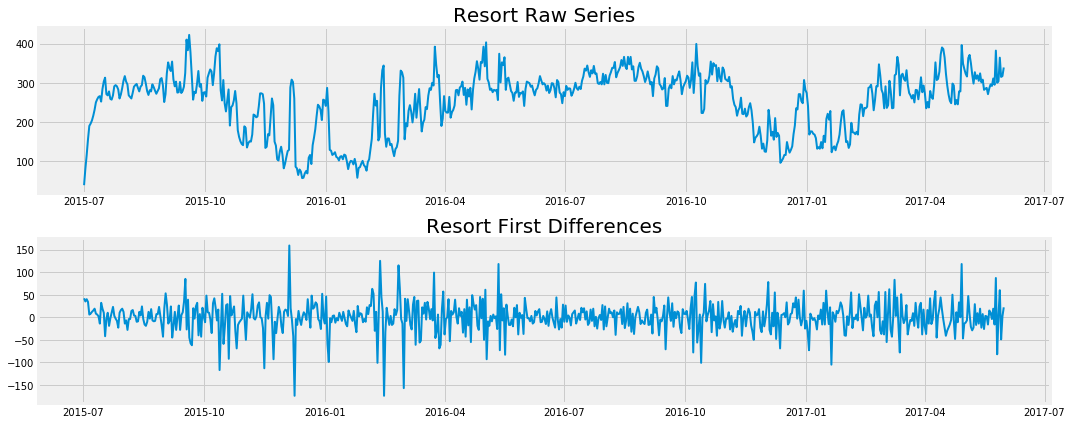

In [15]:
fig, ax = plt.subplots(2, figsize=(15, 6))

plot_trend_data(ax[0], 'Resort', resort_train)
plot_trend_data(ax[1], 'Resort', resort_train.diff()[1:])
ax[0].set_title('Resort Raw Series', fontsize=20)
ax[1].set_title('Resort First Differences', fontsize=20)
fig.tight_layout()

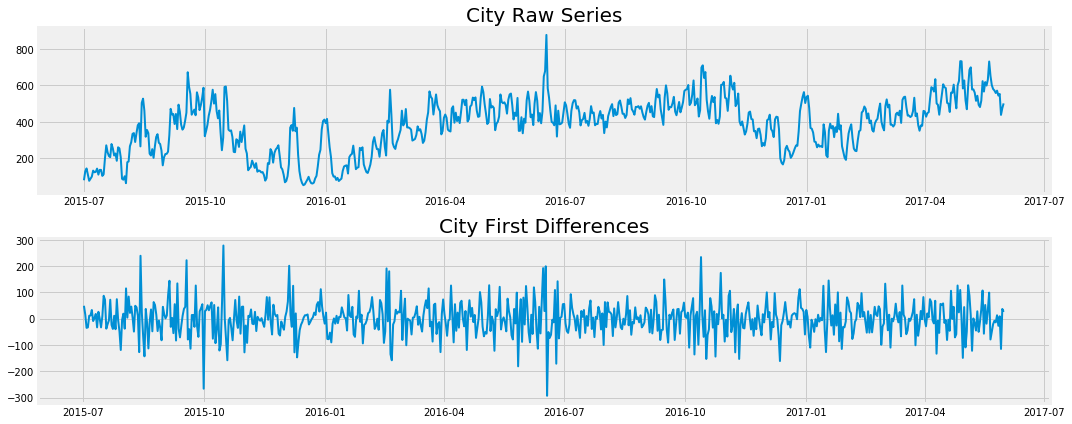

In [16]:
fig, ax = plt.subplots(2, figsize=(15, 6))

plot_trend_data(ax[0], 'City', city_train)
plot_trend_data(ax[1], 'City', city_train.diff()[1:])
ax[0].set_title('City Raw Series', fontsize=20)
ax[1].set_title('City First Differences', fontsize=20)
fig.tight_layout()

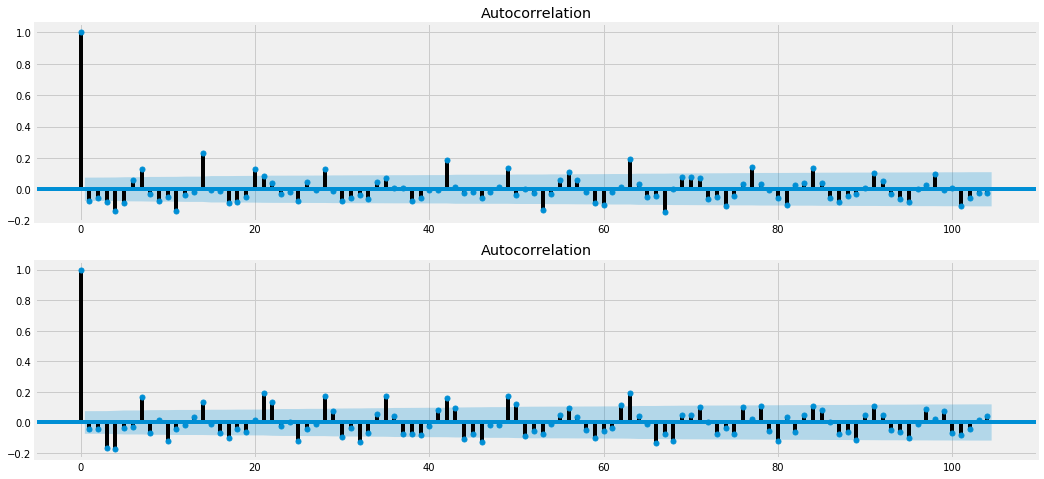

In [17]:
fig, ax = plt.subplots(2, figsize=(16, 8))

_ = sm.graphics.tsa.plot_acf(resort_train.diff()[1:], lags=2*52, ax=ax[0])
_ = sm.graphics.tsa.plot_acf(city_train.diff()[1:], lags=2*52, ax=ax[1])

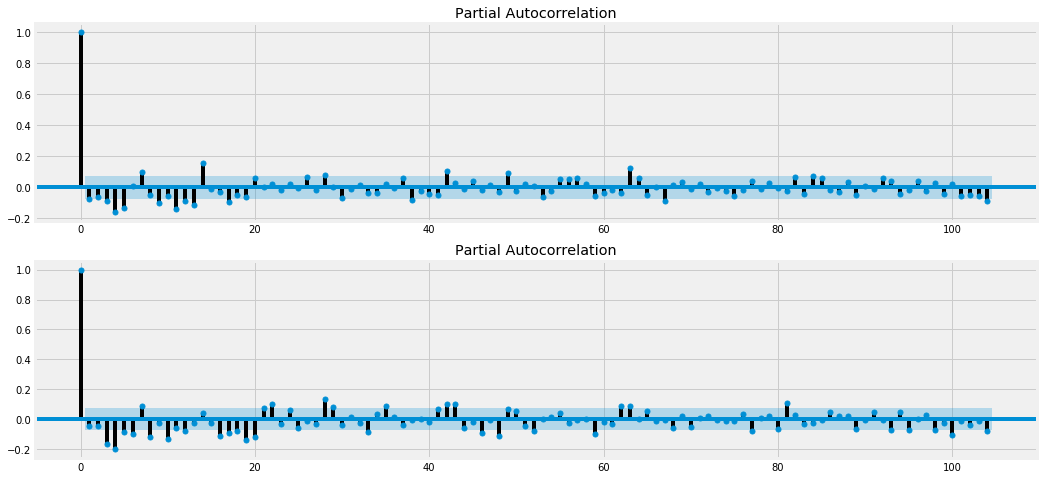

In [18]:
fig, ax = plt.subplots(2, figsize=(16, 8))

_ = sm.graphics.tsa.plot_pacf(resort_train.diff()[1:], lags=2*52, ax=ax[0])
_ = sm.graphics.tsa.plot_pacf(city_train.diff()[1:], lags=2*52, ax=ax[1])

In [21]:
resDiff = sm.tsa.arma_order_select_ic(resort_train, max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

/Users/raficg/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/raficg/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/raficg/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/raficg/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in arctanh
  invarcoefs = 2*np.arctanh(params)


ARMA(p,q) = (6, 5) is the best.


In [22]:
resDiff = sm.tsa.arma_order_select_ic(city_train, max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

/Users/raficg/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/raficg/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/raficg/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/raficg/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/raficg/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+n

ARMA(p,q) = (6, 6) is the best.


/Users/raficg/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/raficg/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [19]:
resort_sarima = sm.tsa.statespace.SARIMAX(resort_train ,order=(6,1,5),seasonal_order=(6,1,5,1),
                                   enforce_stationarity=False, 
                                   enforce_invertibility=False,freq='D').fit()

city_sarima = sm.tsa.statespace.SARIMAX(city_train ,order=(6,1,6),seasonal_order=(6,1,6,1),
                                   enforce_stationarity=False, 
                                   enforce_invertibility=False,freq='D').fit()

/Users/raficg/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/raficg/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Text(0.5, 1.0, 'Resort - SARIMA')

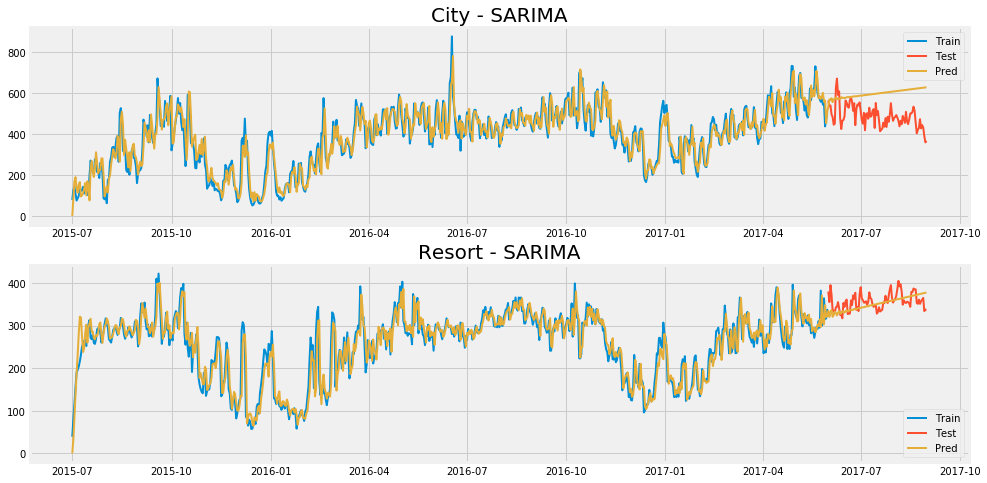

In [20]:
resort_pred = resort_sarima.predict(resort_train.index[0], resort_test.index[-1])
city_pred = city_sarima.predict(city_train.index[0], city_test.index[-1])

fig, ax = plt.subplots(2, figsize=(15, 8))

ax[0].plot(city_train, label='Train', linewidth=2)
ax[0].plot(city_test, label='Test', linewidth=2)
ax[0].plot(city_pred, label='Pred', linewidth=2)
ax[0].legend()
ax[0].set_title('City - SARIMA', fontsize=20)

ax[1].plot(resort_train, label='Train', linewidth=2)
ax[1].plot(resort_test, label='Test', linewidth=2)
ax[1].plot(resort_pred, label='Pred', linewidth=2)
ax[1].legend()
ax[1].set_title('Resort - SARIMA', fontsize=20)

In [25]:
print('City Train RMSE: %0.2f' % (np.sqrt(mean_squared_error(city_train.values, city_pred[0:701]))))
print('City Test RMSE: %0.2f' % (np.sqrt(mean_squared_error(city_test.values, city_pred[701:]))))
print('Resort Train RMSE: %0.2f' % (np.sqrt(mean_squared_error(resort_train.values, resort_pred[0:701]))))
print('Resort Test RMSE: %0.2f' % (np.sqrt(mean_squared_error(resort_test.values, resort_pred[701:]))))

City Train RMSE: 60.30
City Test RMSE: 127.72
Resort Train RMSE: 32.20
Resort Test RMSE: 21.20


# Prophet

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Resort - Prophet')

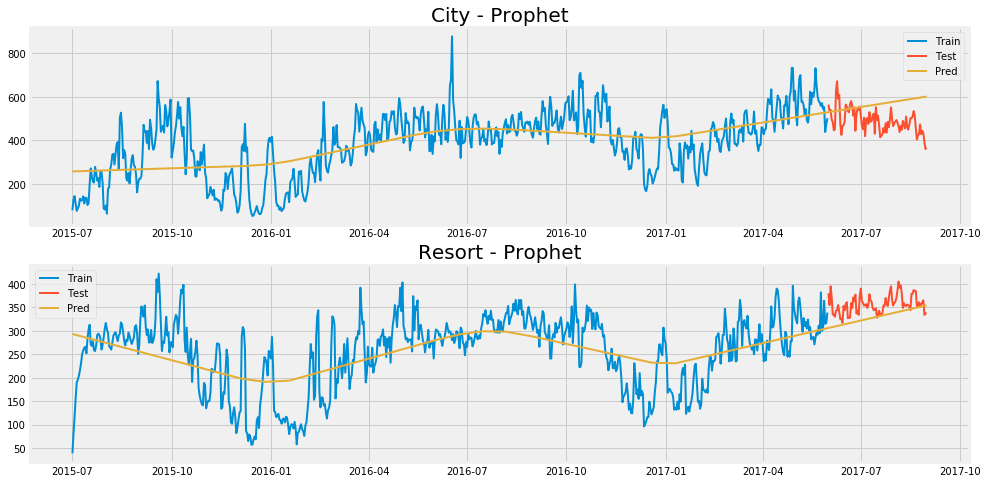

In [26]:
resort_model = Prophet()
resort_df = pd.DataFrame()
resort_df['ds'] = resort_train.index
resort_df['y'] = resort_train.values

resort_model.fit(resort_df)
resort_future = resort_model.make_future_dataframe(periods=365)
resort_forecast = resort_model.predict(resort_future)
resort_pred = resort_forecast[resort_forecast['ds'].isin(resort_train.index) | resort_forecast['ds'].isin(resort_test.index)]


city_model = Prophet()
city_df = pd.DataFrame()
city_df['ds'] = city_train.index
city_df['y'] = city_train.values

city_model.fit(city_df)
city_future = city_model.make_future_dataframe(periods=365)
city_forecast = city_model.predict(city_future)
city_pred = city_forecast[city_forecast['ds'].isin(city_train.index) | city_forecast['ds'].isin(city_test.index)]


fig, ax = plt.subplots(2, figsize=(15, 8))

ax[0].plot(city_train, label='Train', linewidth=2)
ax[0].plot(city_test, label='Test', linewidth=2)
ax[0].plot(city_pred['ds'], city_pred['trend'], label='Pred', linewidth=2)
ax[0].legend()
ax[0].set_title('City - Prophet', fontsize=20)

ax[1].plot(resort_train, label='Train', linewidth=2)
ax[1].plot(resort_test, label='Test', linewidth=2)
ax[1].plot(resort_pred['ds'], resort_pred['trend'], label='Pred', linewidth=2)
ax[1].legend()
ax[1].set_title('Resort - Prophet', fontsize=20)

In [27]:
print('City Train RMSE: %0.2f' % (np.sqrt(mean_squared_error(city_train.values, city_pred.loc[0:700]['trend']))))
print('City Test RMSE: %0.2f' % (np.sqrt(mean_squared_error(city_test.values, city_pred.loc[701:]['trend']))))
print()
print('Resort Train RMSE: %0.2f' % (np.sqrt(mean_squared_error(resort_train.values, resort_pred.loc[0:700]['trend']))))
print('Resort Test RMSE: %0.2f' % (np.sqrt(mean_squared_error(resort_test.values, resort_pred.loc[701:]['trend']))))

City Train RMSE: 114.55
City Test RMSE: 102.46

Resort Train RMSE: 60.83
Resort Test RMSE: 33.15


## RMSE Table


| Model    | City Train | City Test | Resort Train | Resort Test|
|----------|------------|-----------|--------------|------------|
| Baseline | 186.61     | 146.33    | 41.24        | 48.47      |
| SARIMA   | 60.30      | 127.72    | 32.20        | 21.20      |
| Prophet  | 114.55     | 102.46    | 60.83        | 33.15      |

Text(0.5, 1.0, 'Resort - Baseline')

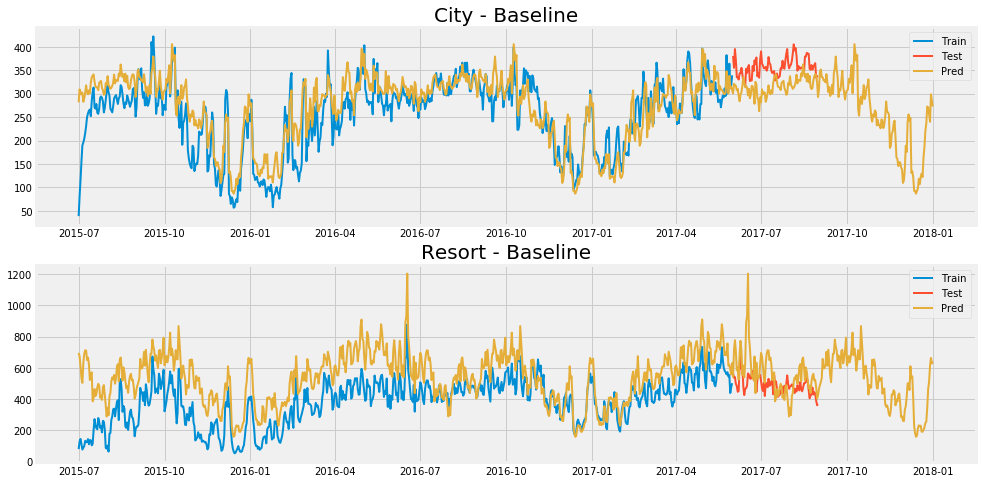

In [28]:
resort_predictions = []
for item in resort_train.index:
    resort_predictions.append(baseline_predict(resort_train, item))
    
for item in resort_test.index:
    resort_predictions.append(baseline_predict(resort_train, item))
    
for item in pd.date_range(start=resort_test.index[-1], end='1/01/2018')[1:]:
    resort_predictions.append(baseline_predict(resort_train, item))
    
city_predictions = []
for item in city_train.index:
    city_predictions.append(baseline_predict(city_train, item))
    
for item in city_test.index:
    city_predictions.append(baseline_predict(city_train, item))
    
for item in pd.date_range(start=city_test.index[-1], end='1/01/2018')[1:]:
    city_predictions.append(baseline_predict(city_train, item))    

    
fig, ax = plt.subplots(2, figsize=(15, 8))

ax[0].plot(resort_train, label='Train', linewidth=2)
ax[0].plot(resort_test, label='Test', linewidth=2)
ax[0].plot(pd.date_range(start=resort_train.index[0], end='1/01/2018'), resort_predictions, label='Pred', linewidth=2)
ax[0].legend()
ax[0].set_title('City - Baseline', fontsize=20)

ax[1].plot(city_train, label='Train', linewidth=2)
ax[1].plot(city_test, label='Test', linewidth=2)
ax[1].plot(pd.date_range(start=city_train.index[0], end='1/01/2018'), city_predictions, label='Pred', linewidth=2)
ax[1].legend()
ax[1].set_title('Resort - Baseline', fontsize=20)

Text(0.5, 1.0, 'Resort - SARIMA')

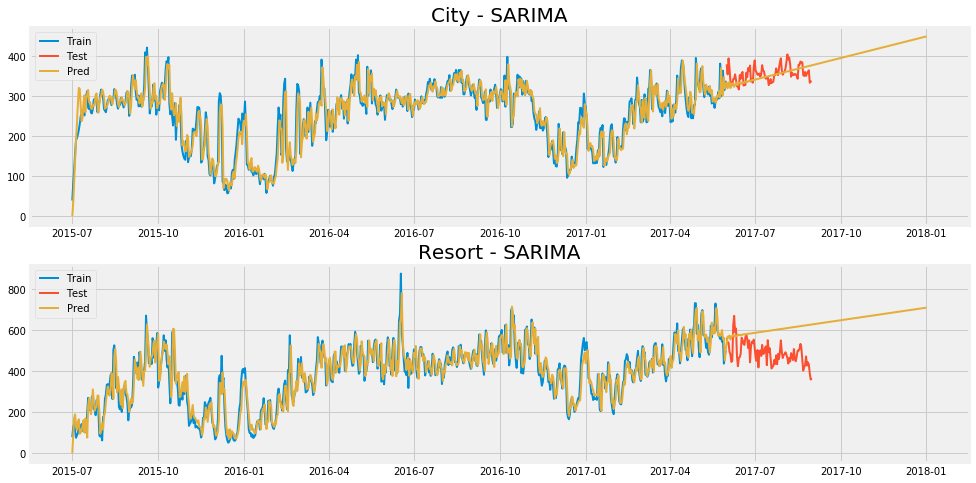

In [29]:
resort_pred = resort_sarima.predict(resort_train.index[0], '2018')
city_pred = city_sarima.predict(city_train.index[0], '2018')

fig, ax = plt.subplots(2, figsize=(15, 8))

ax[0].plot(resort_train, label='Train', linewidth=2)
ax[0].plot(resort_test, label='Test', linewidth=2)
ax[0].plot(resort_pred, label='Pred', linewidth=2)
ax[0].legend()
ax[0].set_title('City - SARIMA', fontsize=20)

ax[1].plot(city_train, label='Train', linewidth=2)
ax[1].plot(city_test, label='Test', linewidth=2)
ax[1].plot(city_pred, label='Pred', linewidth=2)
ax[1].legend()
ax[1].set_title('Resort - SARIMA', fontsize=20)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Resort - Prophet')

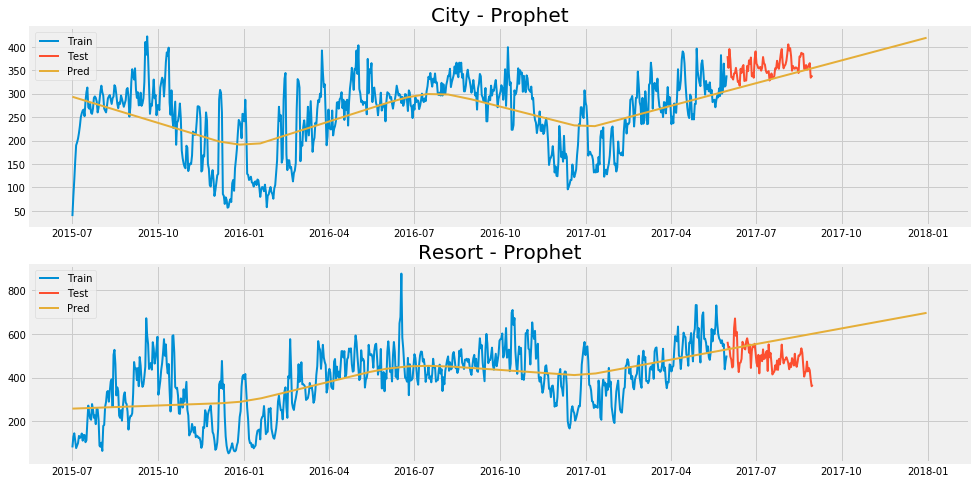

In [30]:
resort_model = Prophet()
resort_df = pd.DataFrame()
resort_df['ds'] = resort_train.index
resort_df['y'] = resort_train.values

resort_model.fit(resort_df)
resort_future = resort_model.make_future_dataframe(periods=365)
resort_forecast = resort_model.predict(resort_future)
resort_pred = resort_forecast[resort_forecast['ds'] < '2018-01-01']

city_model = Prophet()
city_df = pd.DataFrame()
city_df['ds'] = city_train.index
city_df['y'] = city_train.values

city_model.fit(city_df)
city_future = city_model.make_future_dataframe(periods=365)
city_forecast = city_model.predict(city_future)
city_pred = city_forecast[city_forecast['ds'] < '2018-01-01']


fig, ax = plt.subplots(2, figsize=(15, 8))

ax[0].plot(resort_train, label='Train', linewidth=2)
ax[0].plot(resort_test, label='Test', linewidth=2)
ax[0].plot(resort_pred['ds'], resort_pred['trend'], label='Pred', linewidth=2)
ax[0].legend()
ax[0].set_title('City - Prophet', fontsize=20)

ax[1].plot(city_train, label='Train', linewidth=2)
ax[1].plot(city_test, label='Test', linewidth=2)
ax[1].plot(city_pred['ds'], city_pred['trend'], label='Pred', linewidth=2)
ax[1].legend()
ax[1].set_title('Resort - Prophet', fontsize=20)